# Overview
The notebook is mainly done for my own benefit to better understand what graph convolutional networks do on a very basic and visual task (MNIST). 

The notebook is just a slightly more visual version of the MNIST example provided at https://github.com/danielegrattarola/spektral/blob/master/examples/graph_signal_classification_mnist.py as part of the [Spektral](https://github.com/danielegrattarola/spektral) package. 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.util import montage
from IPython.display import Image, display, SVG, clear_output, HTML
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
import networkx as nx
def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.layout.kamada_kawai_layout, draw_labels=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'green'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]
    
    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'black'))
        edge_width.append(g.edges[e].get('width', 0.5))
    nx.draw_networkx_edges(g, pos, font_weight='bold', edge_color=edge_color, width=edge_width, alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='p', node_size=300, alpha=0.75, ax=ax)
    if draw_labels:
        nx.draw_networkx_labels(g, shift_pos, labels=node_labels, arrows=True, ax=ax)
    ax.autoscale()
    return fig, ax, pos

## Libraries
Here are the libraries and imports to make the model

In [4]:
from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, Lambda, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

from spektral.layers import GraphConv, GlobalAttentionPool
from spektral.layers.ops import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian

Using TensorFlow backend.


In [5]:
# Parameters
l2_reg = 5e-4         # Regularization rate for l2
learning_rate = 1e-3  # Learning rate for SGD
batch_size = 16       # Batch size
epochs = 15        # Number of training epochs
es_patience = 10     # Patience fot early stopping

In [6]:
import h5py
from keras.utils.io_utils import HDF5Matrix
_h5_path = '../input/mnist-based-graphs/disjoint_mnist.h5'
raw_h5 = False
strip_xy = False
if raw_h5:
    _bare_h5 = h5py.File(_h5_path, 'r')
    def load_xya(in_id):
        in_group = _bare_h5[in_id]
        feat = in_group['feature']
        labels = in_group['label']
        adj = in_group['adjacency_distance']
        return feat, labels, adj
else:
    def load_xya(in_id, normalize=False):
        # use the hdf5matrix wrapper
        feat = HDF5Matrix(_h5_path, f"{in_id}/feature")
        labels = HDF5Matrix(_h5_path, f"{in_id}/label")
        adj = HDF5Matrix(_h5_path, f"{in_id}/adjacency_distance", normalizer=normalized_laplacian if normalize else None)
        return feat, labels, adj

x_train, y_train, adj_train = load_xya('train')
x_valid, y_valid, adj_valid = load_xya('val')
x_test, y_test, adj_test = load_xya('test')

## Goal
The goal of the problem is to correctly classify the digits using the intensity values as the nodes and the neighborhood relationships as the edges. When we visualize the adjacency matrix we can see the effect of a simply unraveled 2D array

(200, 200) adjacency matrix


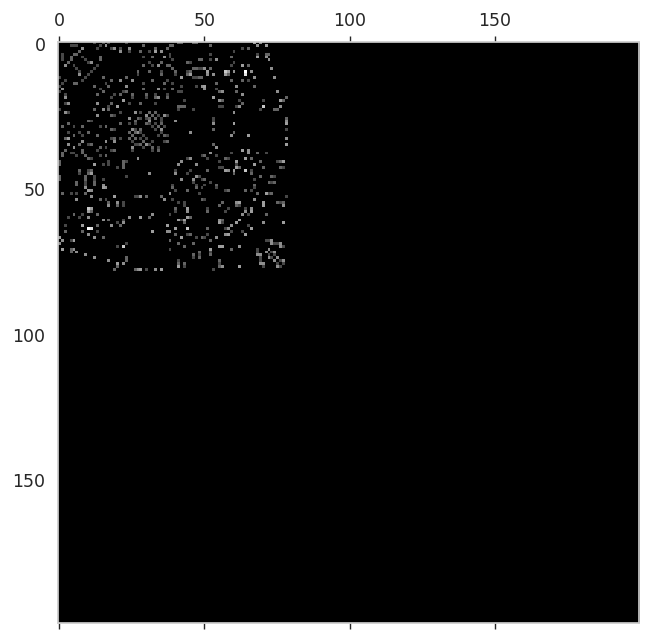

In [7]:
print(adj_train[0].shape, 'adjacency matrix')
plt.matshow(adj_train[0])

### Label Nodes and Show Connections
Here we can visualize the topology a bit better and see what the graph actually looks like.

In [8]:
G = nx.from_numpy_array(adj_train[0])

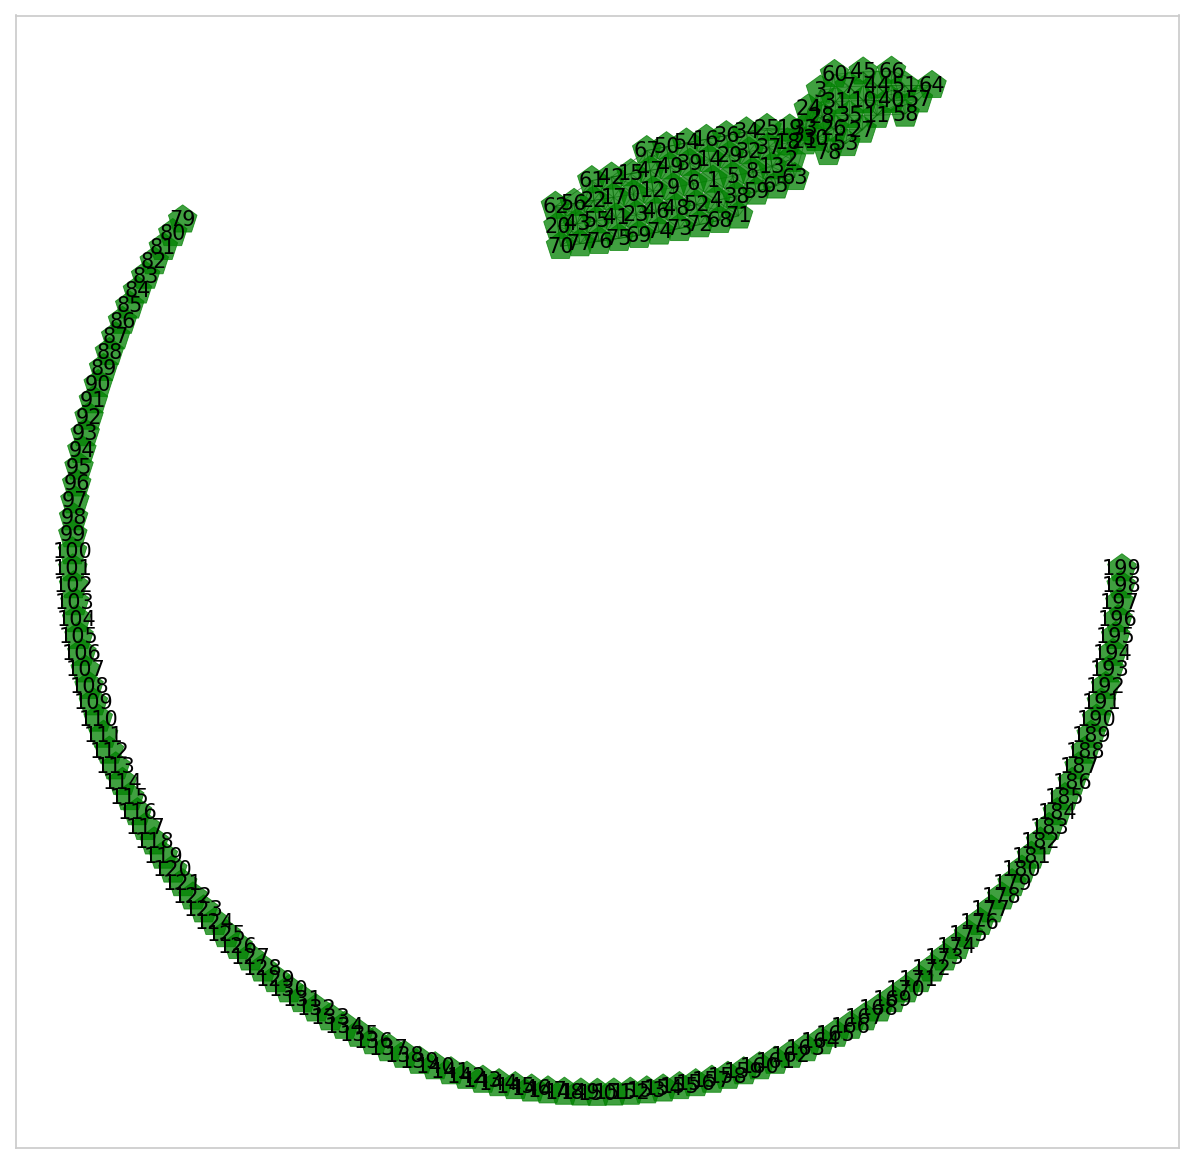

In [9]:
draw_graph_mpl(G);

- Use positions

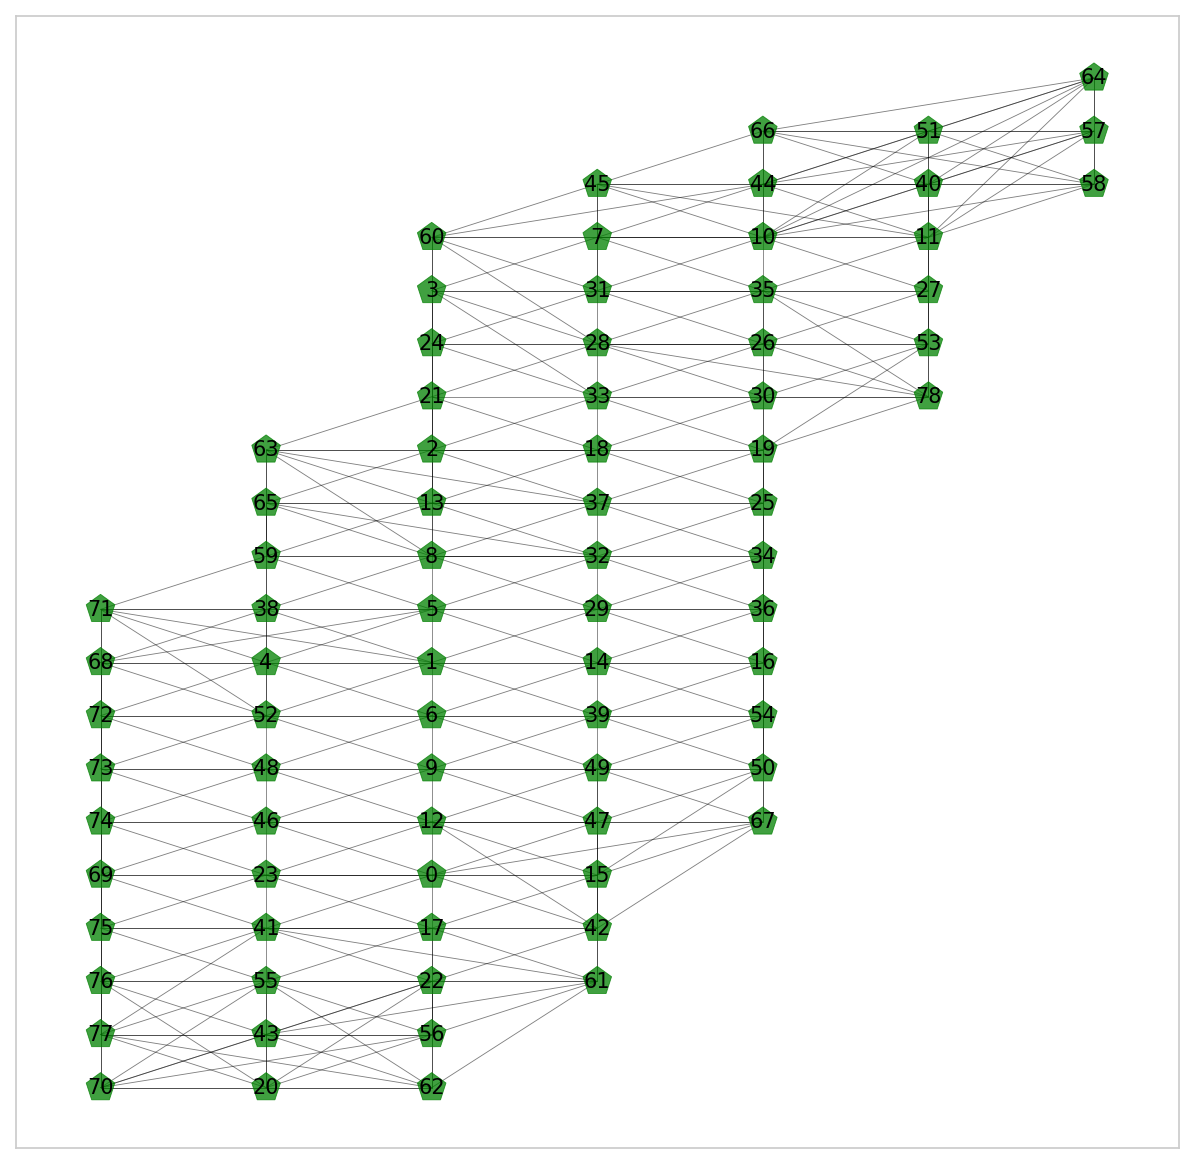

In [10]:
c_pos = x_train[0][:, :2]
c_pos[c_pos==0] = np.NAN
draw_graph_mpl(G, pos=c_pos);

# Model Building
Now we can build the model which uses the graph topology shown above as the basis. We feed the topology in as a constant tensor ($A_{in}$) and the convolutions occur across this topology. 

In [11]:
N = x_train.shape[1]
F = x_train.shape[2]
n_out = np.max(y_train)+1

In [12]:
# Model definition
X_in = Input(shape=(N, F), name='Features')
A_in = Input(shape=(N, N), name='Topology')

if strip_xy:
    clean_x = Lambda(lambda x: x[:, :, 2:], name='StripXY')(X_in)
else:
    clean_x = X_in

graph_conv_1 = GraphConv(32,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg),
                       use_bias=True)([clean_x, A_in])

graph_conv_2 = GraphConv(32,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg),
                       use_bias=True)([graph_conv_1, A_in])

mc_1, A_mincut = graph_conv_2, A_in
# doesn't work yet
#diffpool_1, A_mincut, _ = DiffPool(k=64)([graph_conv_22, A_mincut])

graph_conv_21 = GraphConv(64,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg),
                       use_bias=True)([mc_1, A_mincut])

graph_conv_22 = GraphConv(128,
                       activation='elu',
                       kernel_regularizer=l2(l2_reg),
                       use_bias=True)([graph_conv_21, A_mincut])

gap_1 = GlobalAttentionPool(64)(graph_conv_22)
gap_dr = Dropout(0.5)(gap_1)

fc = Dense(32, activation='relu')(gap_dr)
output = Dense(n_out, activation='softmax')(fc)

# Build model
model = Model(inputs=[X_in, A_in], outputs=output)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Features (InputLayer)           (None, 200, 3)       0                                            
__________________________________________________________________________________________________
Topology (InputLayer)           (None, 200, 200)     0                                            
__________________________________________________________________________________________________
graph_conv_1 (GraphConv)        (None, 200, 32)      128         Features[0][0]                   
                                                                 Topology[0][0]                   
__________________________________________________________________________________________________
graph_conv_2 (GraphConv)        (None, 200, 32)      1056        graph_conv_1[0][0]         

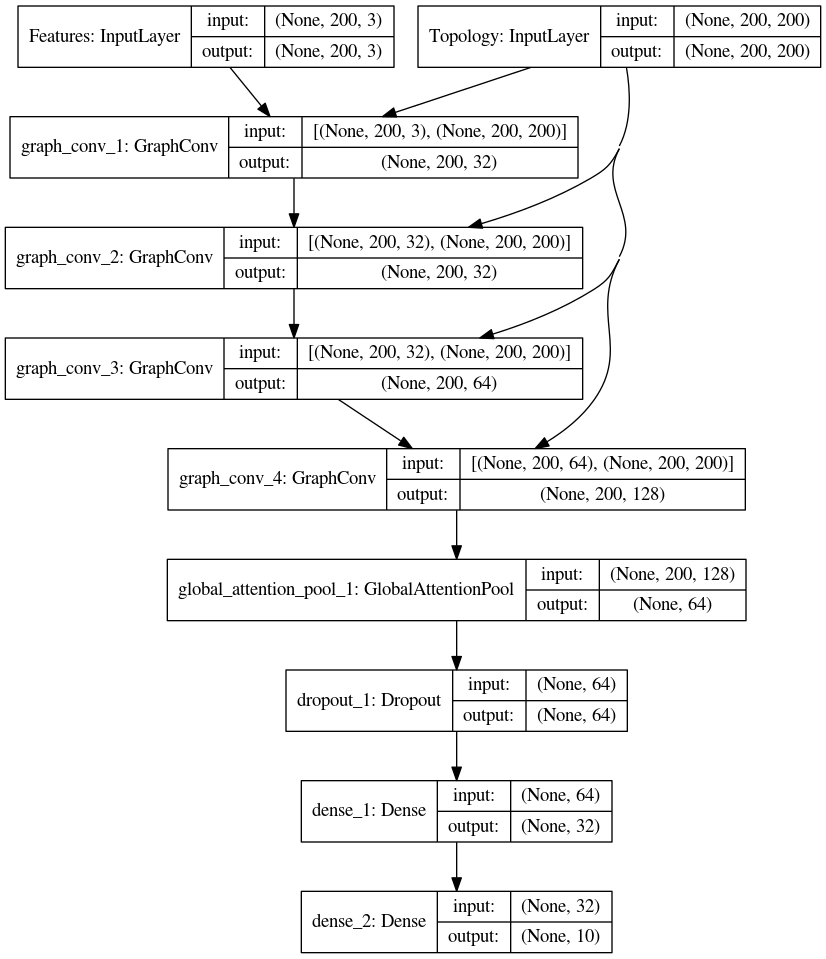

In [13]:
from keras.utils.vis_utils import model_to_dot
Image(model_to_dot(model, show_shapes=True).create_png())

In [14]:
# Train model
validation_data = ({'Features': x_valid, 'Topology': adj_valid}, y_valid)
model.fit({'Features': x_train, 'Topology': adj_train},
          y_train,
          batch_size=batch_size,
          validation_data=validation_data,
          epochs=epochs,
          shuffle="batch",
          callbacks=[
              EarlyStopping(patience=es_patience, restore_best_weights=True)
          ])

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 199s 4ms/step - loss: 2.0909 - acc: 0.2369 - val_loss: 2.0609 - val_acc: 0.2458
Epoch 2/15
50000/50000 [==============================] - 196s 4ms/step - loss: 1.9359 - acc: 0.2910 - val_loss: 1.7731 - val_acc: 0.3609
Epoch 3/15
50000/50000 [==============================] - 197s 4ms/step - loss: 1.7414 - acc: 0.3841 - val_loss: 1.5706 - val_acc: 0.4557
Epoch 4/15
50000/50000 [==============================] - 198s 4ms/step - loss: 1.4904 - acc: 0.4787 - val_loss: 1.2022 - val_acc: 0.6079
Epoch 5/15
46480/50000 [==========================>...] - ETA: 12s - loss: 0.6606 - acc: 0.8196

In [15]:
# Evaluate model
from sklearn.metrics import accuracy_score, confusion_matrix
print('Evaluating model.')
eval_pred = model.predict({'Features': x_test, 'Topology': adj_test},
                              batch_size=batch_size,
                         verbose=True)
eval_cat = np.argmax(eval_pred, -1)

Evaluating model.
10000/10000 [==============================] - 18s 2ms/step


Test acc: 90.0%


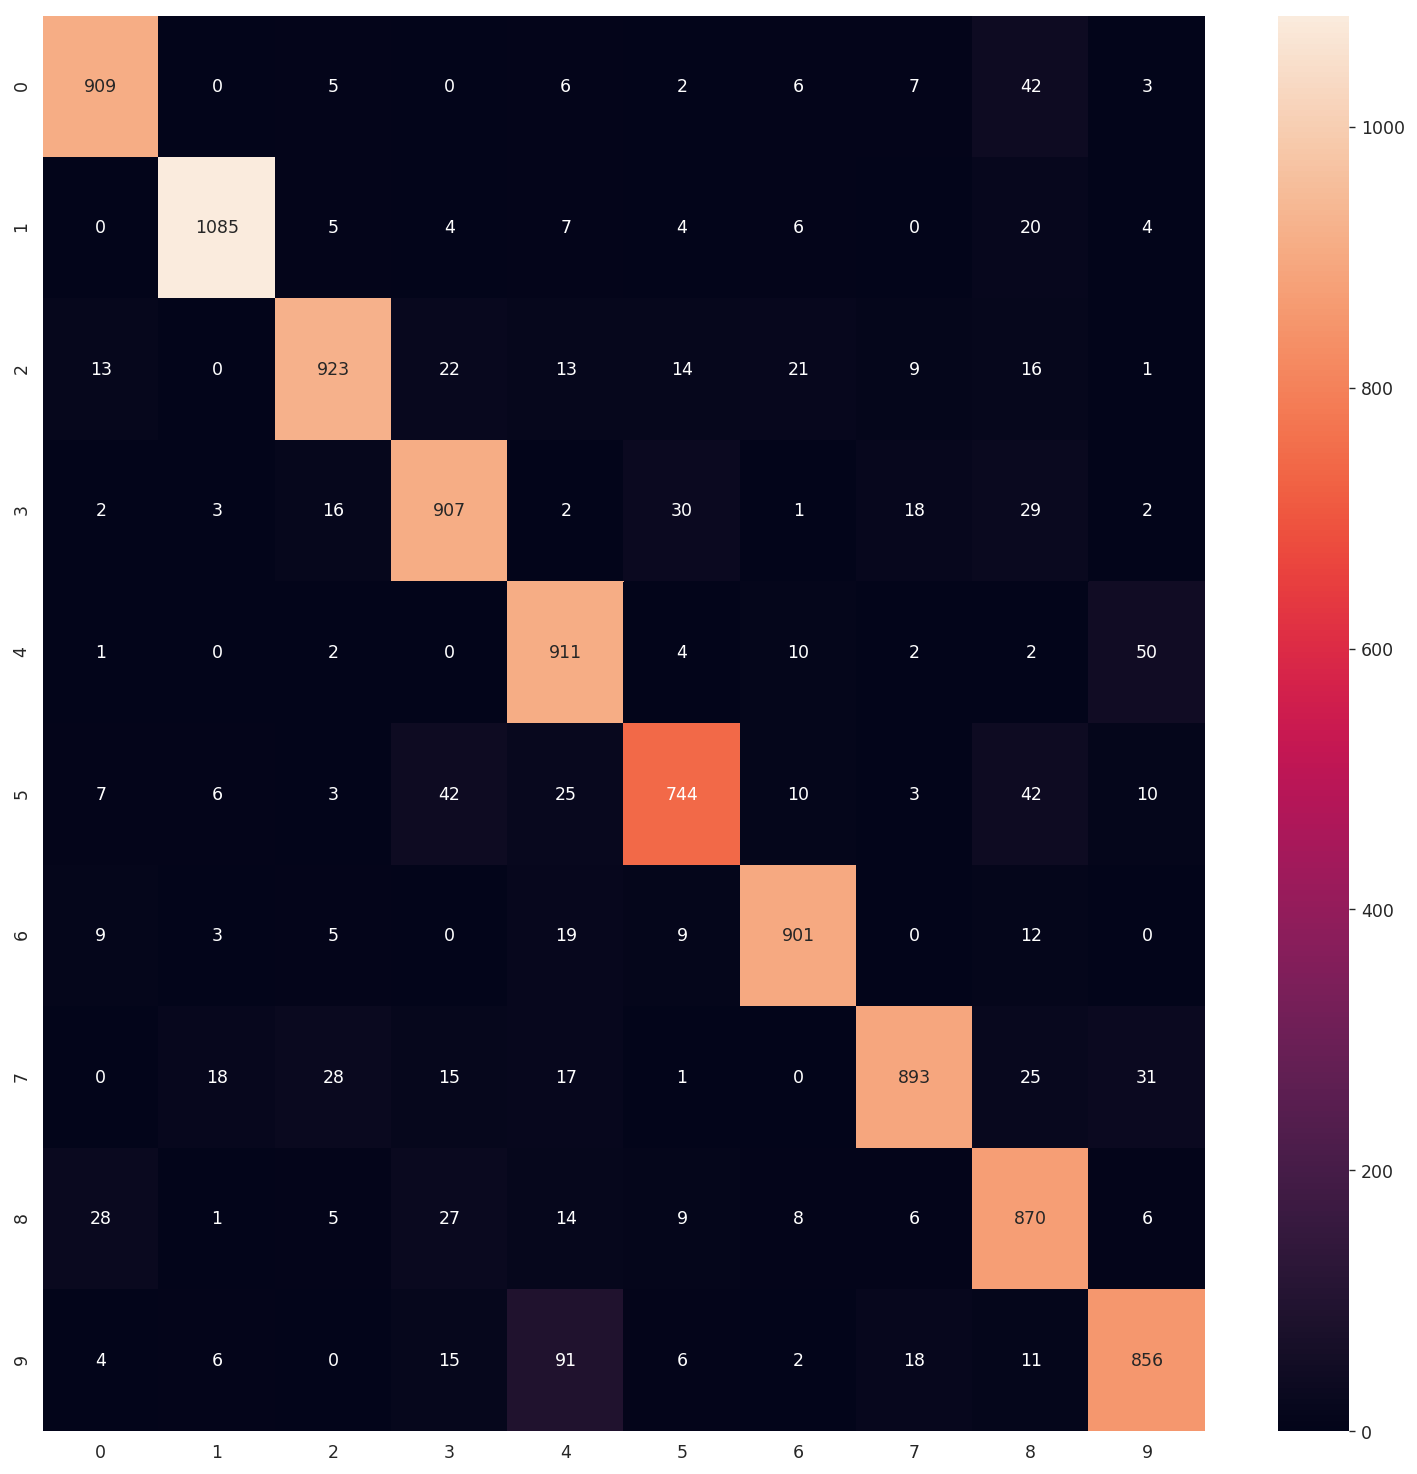

In [16]:
print('Test acc: {:2.1%}'.format(accuracy_score(y_true=y_test[:], y_pred=eval_cat)))
fig, ax1 = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(confusion_matrix(y_true=y_test[:], y_pred=eval_cat), annot=True, fmt='d', ax=ax1)

# What did the model actually learn?
We can now try and reassemble what the model actually learnt by exporting the intermediate layers

# Weights
Not sure exactly how to interpret these but we can show them easily enough

(3, 32) (32,)


<BarContainer object of 32 artists>

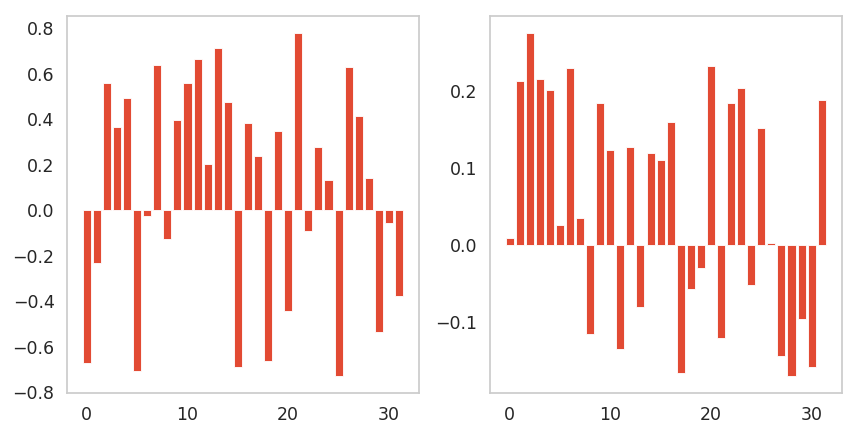

In [17]:
W, b = model.layers[-8].get_weights()
print(W.shape, b.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.bar(np.arange(W.shape[1]), W[0])
ax2.bar(np.arange(W.shape[1]), b)

(32, 32) (32,)


<BarContainer object of 32 artists>

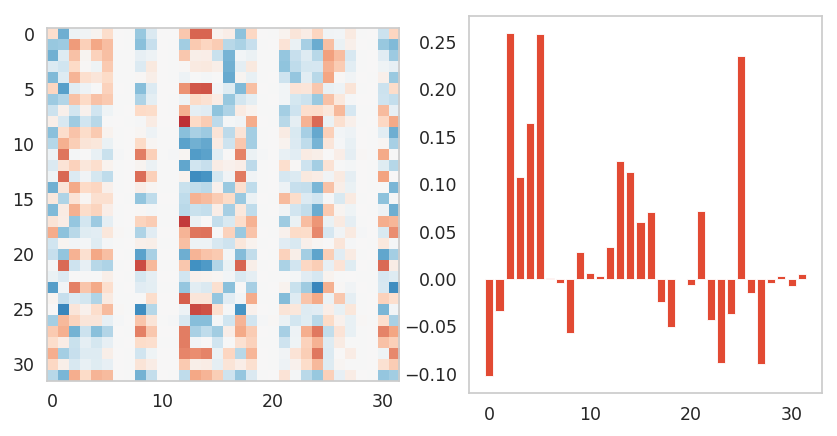

In [18]:
W, b = model.layers[-7].get_weights()
print(W.shape, b.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(W, vmin=-1, vmax=1, cmap='RdBu')
ax2.bar(np.arange(W.shape[1]), b)

(32, 64) (64,)


<BarContainer object of 64 artists>

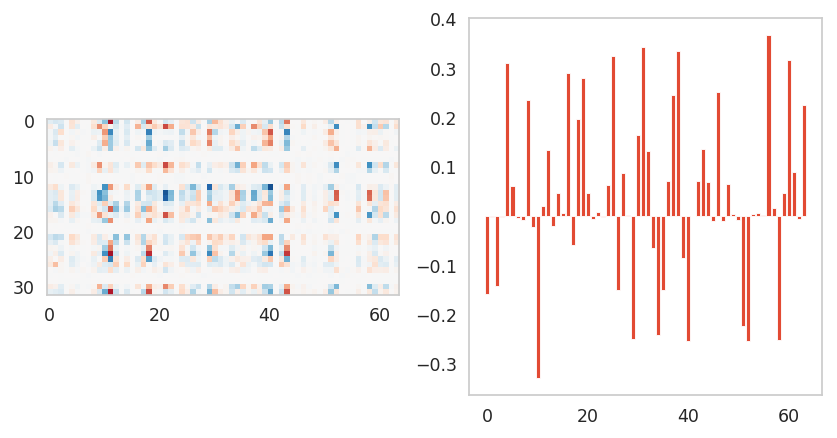

In [19]:
W, b = model.layers[-6].get_weights()
print(W.shape, b.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(W, vmin=-1, vmax=1, cmap='RdBu')
ax2.bar(np.arange(W.shape[1]), b)

(64, 128) (128,)


<BarContainer object of 128 artists>

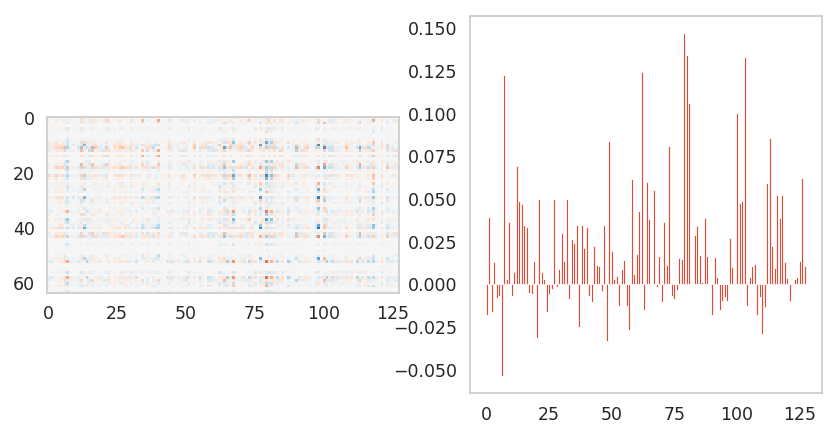

In [20]:
W, b = model.layers[-5].get_weights()
print(W.shape, b.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(W, vmin=-1, vmax=1, cmap='RdBu')
ax2.bar(np.arange(W.shape[1]), b)

(128, 64) (128, 64) (64,) (64,)


<BarContainer object of 64 artists>

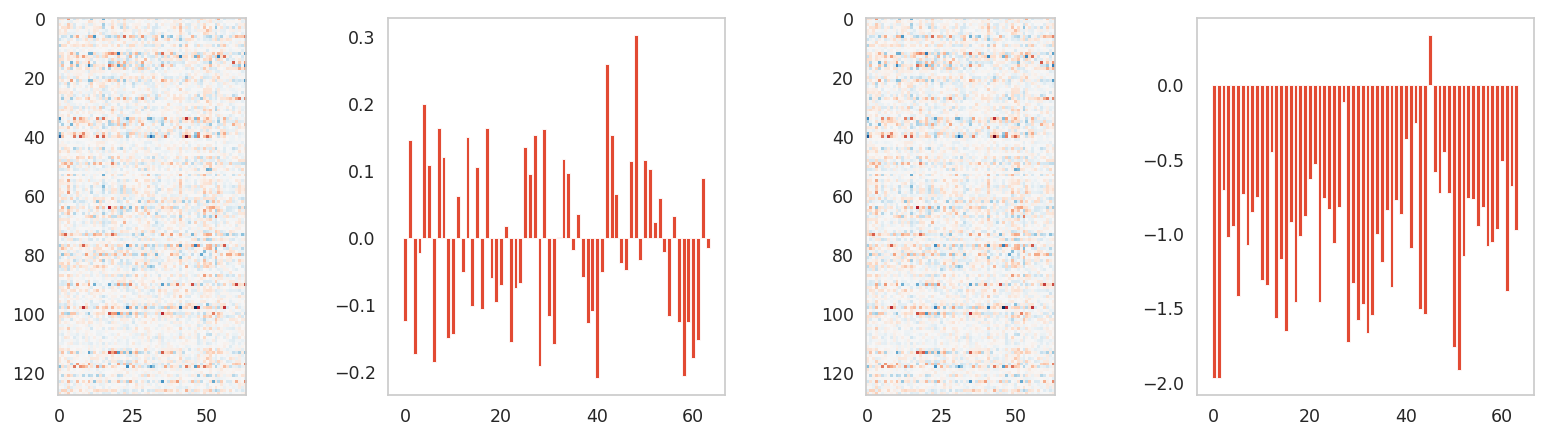

In [21]:
W1, b1, W2, b2  = model.layers[-4].get_weights()
print(W1.shape, W2.shape, b1.shape, b2.shape)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
ax1.imshow(W1, vmin=-1, vmax=1, cmap='RdBu')
ax2.bar(np.arange(b1.shape[0]), b1)
ax3.imshow(W1, vmin=-1, vmax=1, cmap='RdBu')
ax4.bar(np.arange(b2.shape[0]), b2)

(64, 32) (32,)


<BarContainer object of 32 artists>

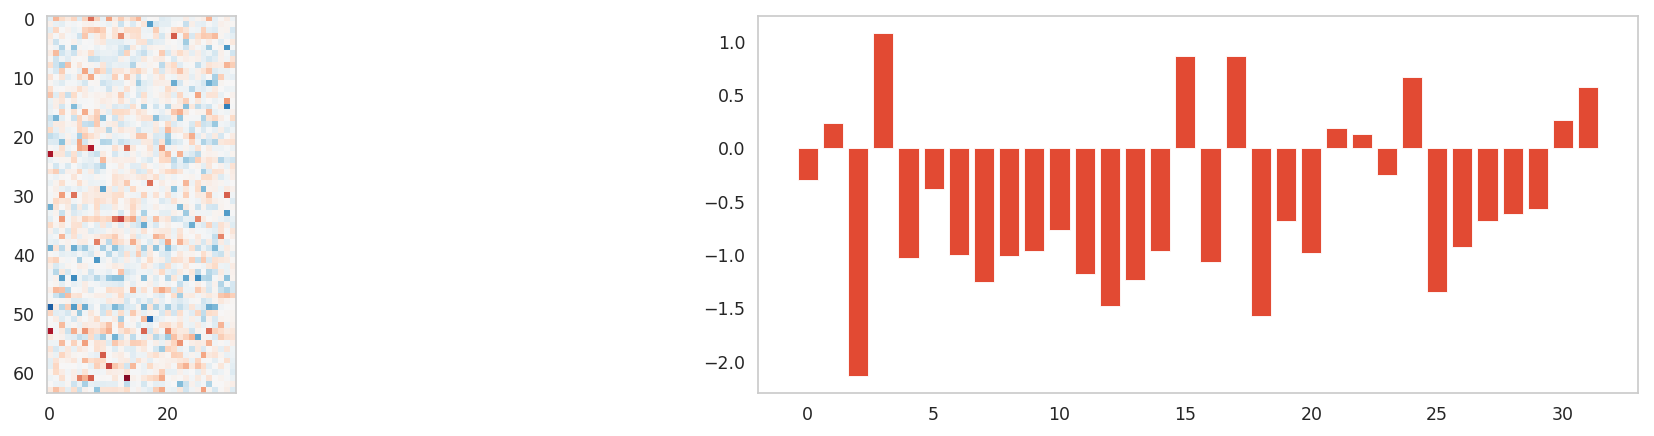

In [22]:
W, b = model.layers[-2].get_weights()
print(W.shape, b.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
ax1.imshow(W, vmin=-1, vmax=1, cmap='RdBu')
ax2.bar(np.arange(W.shape[1]), b)

## Show intermediate output values
Here we can rearrange the output of the graph convolutions to see if the model is learning similar sorts of features to the standard convolutional neural networks

In [23]:
i_model = Model(inputs=[X_in, A_in], outputs=[graph_conv_1, graph_conv_2, graph_conv_21, graph_conv_22, gap_1])

In [24]:
*conv_outputs, gap_out = i_model.predict({'Features': x_test[:512], 'Topology': adj_test[:512]})

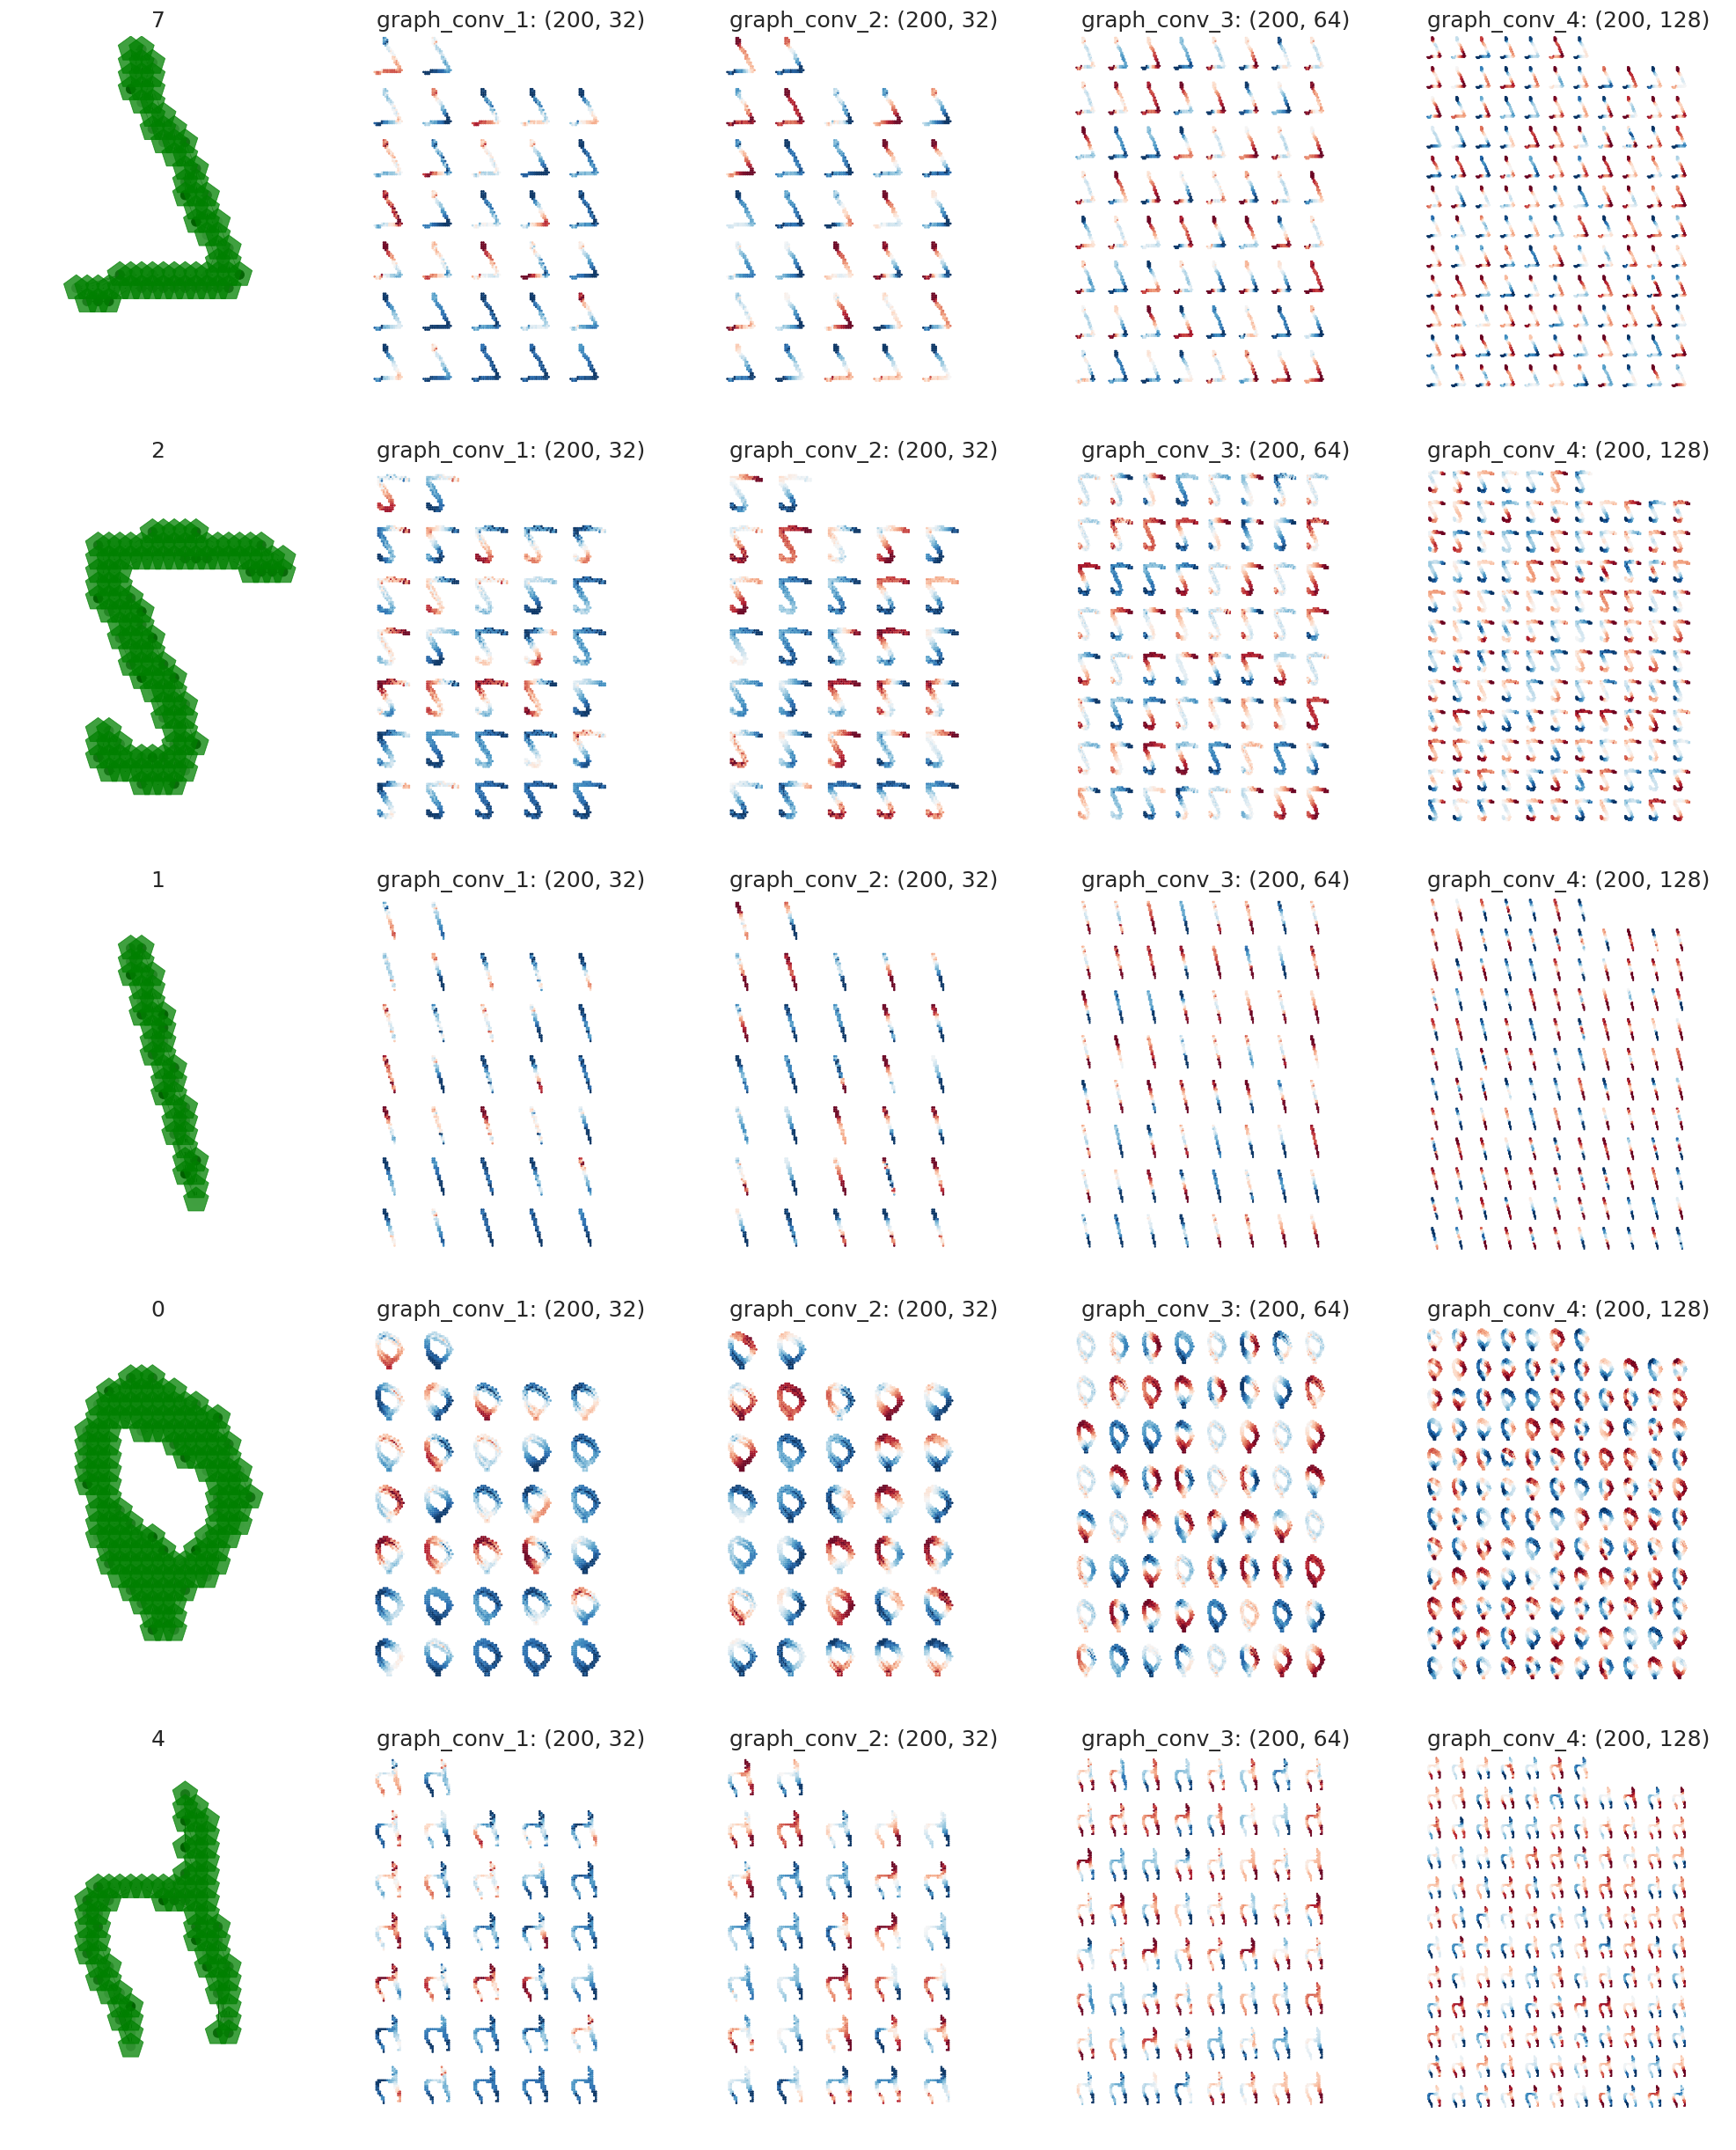

In [25]:
fig, m_axs = plt.subplots(5, 1+len(conv_outputs), figsize=(20, 5*(1+len(conv_outputs))))
for c_ax in m_axs.flatten():
    c_ax.set_xlim(0, 1)
    c_ax.set_ylim(0, 1)
    c_ax.axis('off')
def show_wrapped(in_ax, in_pos, in_vec):
    row_count = np.sqrt(in_vec.shape[1]).astype(int)
    max_x, max_y = 0, 0
    for i in range(in_vec.shape[1]):
        x_offset = i % row_count
        max_x = max(x_offset, max_x)
        y_offset = i // row_count
        max_y = max(y_offset, max_y)
        nmax_val = np.percentile(np.abs(in_vec[:, i]), 95)
        in_ax.scatter(in_pos[:, 0]+x_offset, 
                      in_pos[:, 1]+y_offset, 
                      c=in_vec[:, i], 
                      s=5/row_count, 
                      cmap='RdBu', 
                      vmin=-nmax_val, 
                      vmax=nmax_val)
    in_ax.set_xlim(0, row_count+1)
    in_ax.set_ylim(0, max_y+1)

for i, n_axs in enumerate(m_axs):
    ax1, *r_axs = n_axs
    x_vec = x_test[i]
    pos_vec = x_vec[:, :2].copy()
    pos_vec[pos_vec==0] = np.NAN
    x_topo = adj_test[i]
    G = nx.from_numpy_array(x_topo)
    draw_graph_mpl(G, pos=pos_vec, ax=ax1, draw_labels=False);
    ax1.scatter(pos_vec[:, 0], pos_vec[:, 1], c=x_vec[:, 2])
    ax1.set_title(y_test[i])
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    for j, (c_ax, conv_out) in enumerate(zip(r_axs, conv_outputs)):
        show_wrapped(c_ax, in_pos=pos_vec, in_vec=conv_out[i])
        c_ax.set_title('{}: {}'.format(i_model.output_names[j], conv_out[i].shape))
fig.savefig('layer_activations.png', dpi=300)

## Global Attention Features
- What sort of features do we have after the attention layer
- Are there easily distinguishable between digits?

Text(0.5, 1.0, 'Combined')

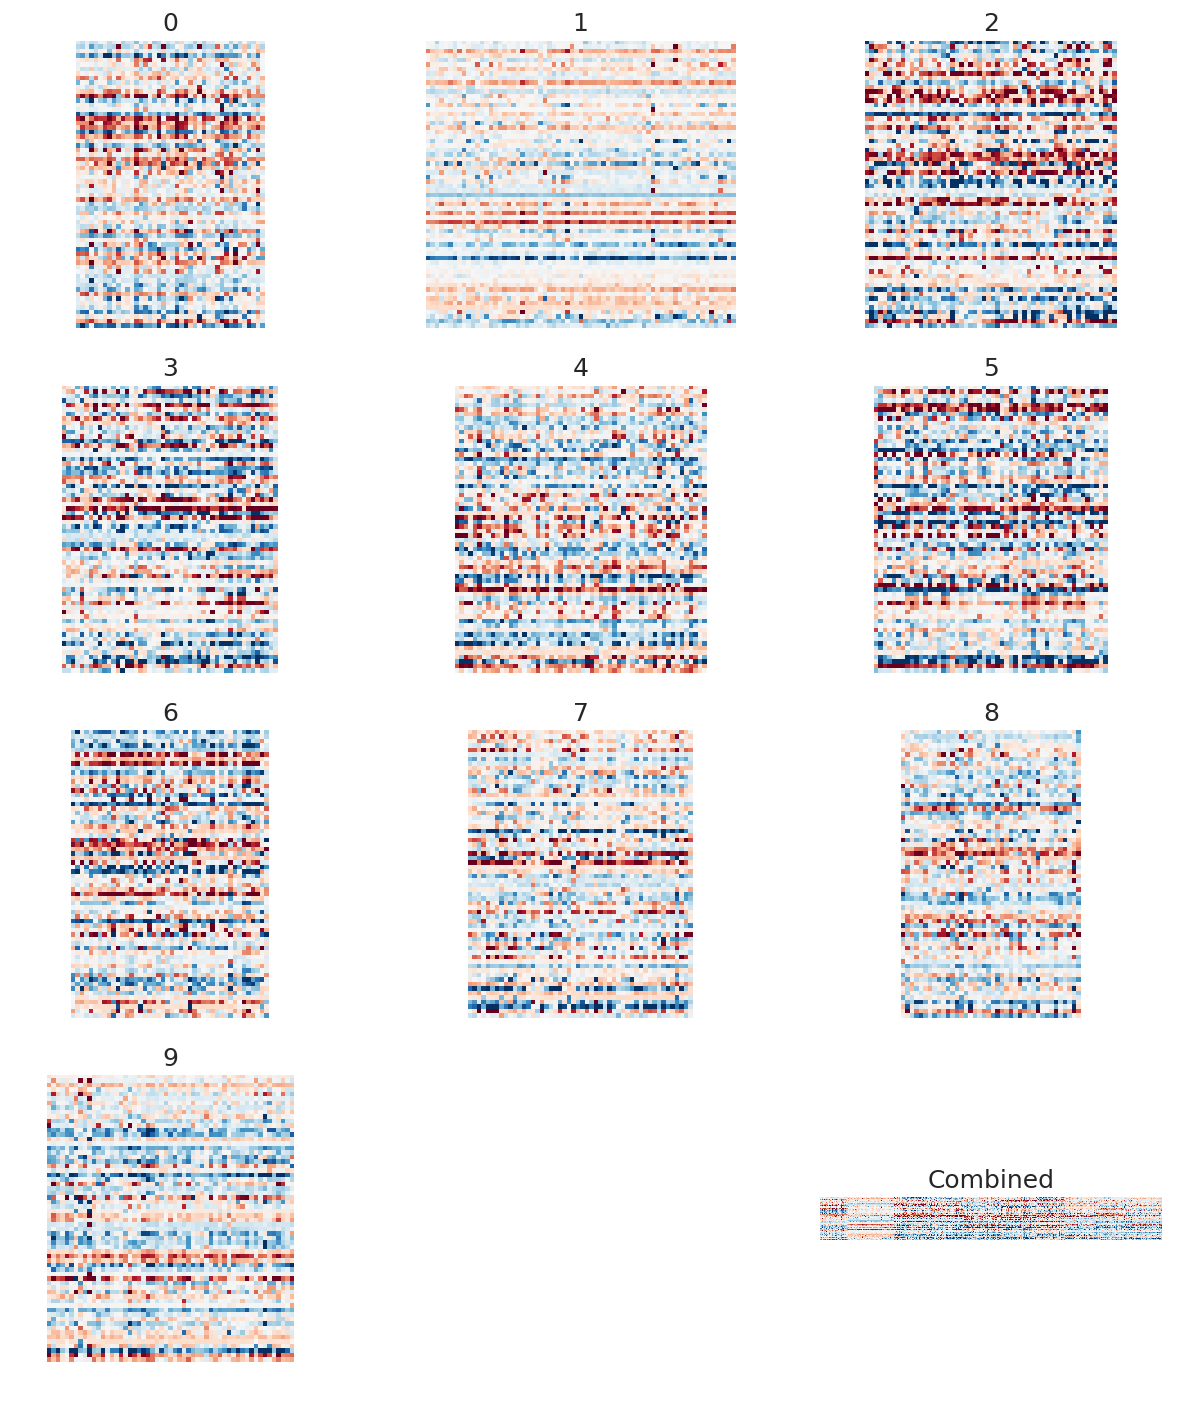

In [26]:
n_keys = y_test[:gap_out.shape[0]]
fig, m_axs = plt.subplots(4, 3, figsize=(12, 14))
m_val = np.percentile(np.abs(gap_out.ravel()), 95)
out_img_list = []
for i, c_ax in enumerate(m_axs.flatten()):
    c_img = gap_out[n_keys==i, :]
    if c_img.shape[0]>0:
        out_img_list.append(c_img)
        c_ax.imshow(c_img.T, vmin=-m_val, vmax=m_val, cmap='RdBu')
        c_ax.set_title(i)
    c_ax.axis('off')
m_axs.ravel()[-1].imshow(np.concatenate(out_img_list, 0).T, vmin=-m_val, vmax=m_val, cmap='RdBu')
m_axs.ravel()[-1].set_title('Combined')